# (VAD) Velocity Azimuth Display

Argonne National Laboratory

Original code by Jonathan Helmus

In [15]:
import glob
from matplotlib import animation
import matplotlib.pyplot as plt
import numpy.ma as ma
import numpy as np
import pyart
# import warnings
# warnings.filterwarnings("ignore")
%matplotlib inline

In [7]:
"""
pyart.retrieve.velocity_azimuth_display
=======================================

Retrieval of VADs from a radar object.

.. autosummary::
    :toctreeL generated/
    :template: dev_template.rst

    velocity_azimuth_display
    _vad_calculation
    _inverse_dist_squared
    _Average1D

"""

import numpy as np

from pyart.core import HorizontalWindProfile


def velocity_azimuth_display(
        radar, velocity, z_want=None,
        valid_ray_min=16, gatefilter=None, window=2,
        weight='equal'):
    """
    Velocity azimuth display.

    Note: If a specific sweep is desired, before using the
    velocity_azimuth_display function, use, for example:
    one_sweep_radar = radar.extract_sweeps([0])

    Parameters
    ----------
    radar : Radar
        Radar object used.
    velocity : string
        Velocity field to use for VAD calculation.

    Other Parameters
    ----------------
    z_want : array
        Array of desired heights to be sampled for the vad
        calculation.
    valid_ray_min : int
        Amount of rays required to include that level in
        the VAD calculation.
    gatefilter : GateFilter
        A GateFilter indicating radar gates that should be excluded when
        from the vad calculation.
    window : int
        Value to use for window when determing new values in the
        _Averag1D function.
    weight : string
        A string to indicate weighting method to use. 'equal' for
        equal weighting when interpolating or 'idw' for inverse
        distribution squared weighting for interpolating.
        Default is 'equal'.

    Returns
    -------
    height : array
        Heights in meters above sea level at which horizontal winds were
        sampled.
    speed : array
        Horizontal wind speed in meters per second at each height.
    direction : array
        Horizontal wind direction in degrees at each height.
    u_wind : array
        U-wind mean in meters per second.
    v_wind : array
        V-wind mean in meters per second.

    Reference
    ----------
    K. A. Browning and R. Wexler, 1968: The Determination
    of Kinematic Properties of a Wind Field Using Doppler
    Radar. J. Appl. Meteor., 7, 105–113

    """
    velocities = radar.fields[velocity]['data']
    if gatefilter is not None:
        velocities = np.ma.masked_where(
            gatefilter.gate_excluded, velocities)
    #mask=velocities.mask
    #velocities[np.where(mask)]=np.nan
    azimuths = radar.azimuth['data'][:]
    elevation = radar.fixed_angle['data'][0]

    u_wind, v_wind = _vad_calculation(velocities, azimuths,
                                      elevation, valid_ray_min)
    bad = np.logical_or(np.isnan(u_wind), np.isnan(v_wind))
    good_u_wind = u_wind[~bad]
    good_v_wind = v_wind[~bad]

    radar_height = radar.gate_z['data'][0]
    good_height = radar_height[~bad]
    if z_want is None:
        z_want = np.linspace(0, 1000, 100)
    else:
        z_want
    try:
        print('max height', np.max(good_height), ' meters')
        print('min height', np.min(good_height), ' meters')
    except ValueError:
        raise ValueError('Not enough data in this radar sweep ' \
                         'for a vad calculation.')

    u_interp = _Average1D(good_height, good_u_wind,
                          z_want[1] - z_want[0] / window, weight)
    v_interp = _Average1D(good_height, good_v_wind,
                          z_want[1] - z_want[0] / window, weight)

    u_wanted = u_interp(z_want)
    v_wanted = v_interp(z_want)
    u_wanted = np.ma.masked_equal(u_wanted, 99999.)
    v_wanted = np.ma.masked_equal(v_wanted, 99999.)

    vad = HorizontalWindProfile.from_u_and_v(
        z_want, u_wanted, v_wanted)
    return vad

def _vad_calculation(velocities, azimuths,
                     elevation, valid_ray_min):
    """ Calculates VAD for a scan and returns u_mean and
    v_mean. velocities is a 2D array, azimuths is a 1D
    array, elevation is a number.

    Jonathan's Note:
    We need to solve: Ax = b
    where:
    A = [sum_sin_squared_az, sum_sin_cos_az    ] = [a, b]
        [sum_sin_cos_az,     sum_cos_squared_az]   [c, d]
    b = [sum_sin_vel_dev] = [b_1]
        [sum_cos_vel_dev]   [b_2]
    The solution to this is:
    x = A-1 * b

    A-1 is:
     1    [ d,  -b ]
    --- * [ -c,  a ]
    |A|

    and the determinate, det is: det = a*d - b*c

    Therefore the elements of x are:

    x_1 = (d* b_1  + -b * b_2) / det = (d*b_1 - b*b_2) / det
    x_2 = (-c * b_1 +  a * b_2) / det = (a*b_2 - c*b_1) / det

    """
    velocities = velocities.filled(np.nan)
    shape = velocities.shape
    _, nbins = velocities.shape

    invalid = np.isnan(velocities)
    valid_rays_per_gate = np.sum(~np.isnan(velocities), axis=0)
    too_few_valid_rays = valid_rays_per_gate < valid_ray_min
    invalid[:, too_few_valid_rays] = True

    sin_az = np.sin(np.deg2rad(azimuths))
    cos_az = np.cos(np.deg2rad(azimuths))
    sin_az = np.repeat(sin_az, nbins).reshape(shape)
    cos_az = np.repeat(cos_az, nbins).reshape(shape)
    sin_az[invalid] = np.nan
    cos_az[invalid] = np.nan

    mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)
    velocity_deviation = velocities - mean_velocity_per_gate

    sum_cos_vel_dev = np.nansum(cos_az * velocity_deviation, axis=0)
    sum_sin_vel_dev = np.nansum(sin_az * velocity_deviation, axis=0)

    sum_sin_cos_az = np.nansum(sin_az * cos_az, axis=0)
    sum_sin_squared_az = np.nansum(sin_az**2, axis=0)
    sum_cos_squared_az = np.nansum(cos_az**2, axis=0)

    # The A matrix
    a = sum_sin_squared_az
    b = sum_sin_cos_az
    c = sum_sin_cos_az
    d = sum_cos_squared_az

    # The b vector
    b_1 = sum_sin_vel_dev
    b_2 = sum_cos_vel_dev

    # solve for the x vector
    determinant = a*d - b*c
    x_1 = (d*b_1 - b*b_2) / determinant
    x_2 = (a*b_2 - c*b_1) / determinant

    # calculate horizontal components of winds
    elevation_scale = 1 / np.cos(np.deg2rad(elevation))
    u_mean = x_1 * elevation_scale
    v_mean = x_2 * elevation_scale
    return u_mean, v_mean


def _inverse_dist_squared(dist):
    """ Obtaining distance weights by using distance weighting
    interpolation, using the inverse distance-squared relationship.
    """
    weights = 1 / (dist * dist)
    weights[np.isnan(weights)] = 99999.
    return weights


class _Average1D(object):
    """ Used to find the nearest gate height and horizontal wind
    value with respect to the user's desired height. """
    def __init__(self, x, y, window, weight,
                 fill_value=99999.):
        sort_idx = np.argsort(x)
        self.x_sorted = x[sort_idx]
        self.y_sorted = y[sort_idx]
        self.window = window
        self.fill_value = fill_value

        if weight == 'equal':
            self.weight_func = lambda x: None
        elif weight == 'idw':
            self.weight_func = _inverse_dist_squared
        elif callable(weight):
            self.weight_func = weight
        else:
            raise ValueError("Invalid weight argument:", weight)

    def __call__(self, x_new, window=None):
        if window is None:
            window = self.window
        y_new = np.zeros_like(x_new, dtype=self.y_sorted.dtype)
        for i, center in enumerate(x_new):

            bottom = center - window
            top = center + window
            start = np.searchsorted(self.x_sorted, bottom)
            stop = np.searchsorted(self.x_sorted, top)

            x_in_window = self.x_sorted[start:stop]
            y_in_window = self.y_sorted[start:stop]
            if len(x_in_window) == 0:
                y_new[i] = self.fill_value
            else:
                distances = x_in_window - center
                weights = self.weight_func(distances)
                y_new[i] = np.average(y_in_window, weights=weights)
        return y_new

max height: 707.136208968
max height 707.136208968  meters
min height 0.0  meters


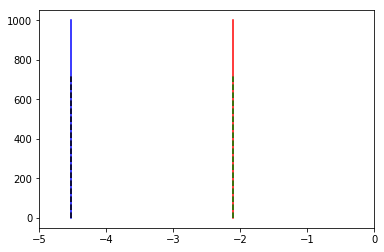

Height
[  0.         10.1010101  20.2020202  30.3030303  40.4040404]
[  0.         10.1010101  20.2020202  30.3030303  40.4040404]
[  959.5959596   969.6969697   979.7979798   989.8989899  1000.       ]
[  959.5959596   969.6969697   979.7979798   989.8989899  1000.       ]
u_wind:
[-2.11309131 -2.11309131 -2.11309131 -2.11309131 -2.11309131]
[-2.113091255279754 -2.113091255279754 -2.113091255279754
 -2.113091255279754 -2.113091255279754]
[-2.11309131 -2.11309131 -2.11309131 -2.11309131 -2.11309131]
[-- -- -- -- --]
v_wind:
[-4.53153894 -4.53153894 -4.53153894 -4.53153894 -4.53153894 -4.53153894
 -4.53153894 -4.53153894 -4.53153894 -4.53153894 -4.53153894 -4.53153894
 -4.53153894 -4.53153894 -4.53153894 -4.53153894 -4.53153894 -4.53153894
 -4.53153894 -4.53153894 -4.53153894 -4.53153894 -4.53153894 -4.53153894
 -4.53153894 -4.53153894 -4.53153894 -4.53153894 -4.53153894 -4.53153894
 -4.53153894 -4.53153894 -4.53153894 -4.53153894 -4.53153894 -4.53153894
 -4.53153894 -4.53153894 -4.5315

/home/zsherman/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-05-01 15:19:35.197574. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [10]:
# create a profile of 100 heights up to 500 m with 5 m/s winds at 25 degrees
height = np.linspace(0, 1000, 100)
speed = np.ones_like(height) * 5
direction = np.ones_like(height) * 25
profile = pyart.core.HorizontalWindProfile(height, speed, direction)

# simulate a single sweep radar with a velocity field from the profile
test_radar = pyart.testing.make_target_radar()
test_radar.elevation['data'][:] = 45.0
test_radar.fixed_angle['data'][:] = 45.0
print("max height:", test_radar.gate_z['data'].max())
sim_vel = pyart.util.simulated_vel_from_profile(test_radar, profile)
test_radar.add_field('velocity', sim_vel, replace_existing=True)

# perform a VAD retrieval
vad_test = velocity_azimuth_display(
    test_radar, 'velocity', valid_ray_min=16,
    z_want=height, window=2,
    gatefilter=None)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(profile.u_wind, profile.height, 'r-')
ax.plot(profile.v_wind, profile.height, 'b-')

ax.plot(vad_test.u_wind, vad_test.height, 'g--')
ax.plot(vad_test.v_wind, vad_test.height, 'k--')

ax.set_xlim(-5, 0)
plt.show()
# print out the results
print("Height")
print(profile.height[:5])
print(vad_test.height[:5])
print(profile.height[-5:])
print(vad_test.height[-5:])

print("u_wind:")
print(profile.u_wind[:5])
print(vad_test.u_wind[:5])
print(profile.u_wind[-5:])
print(vad_test.u_wind[-5:])

print("v_wind:")
print(profile.v_wind)
print(vad_test.v_wind)
#print(profile.v_wind[-5:])
#print(vad_test.v_wind[-5:])

print("speed:")
print(profile.speed[:5])
print(vad_test.speed[:5])
print(vad_test.speed[-5:])
print("direction:")
print(profile.direction[:5])
print(vad_test.direction[:5])
print(vad_test.direction[-5:])

In [8]:
filename = '/home/zsherman/dev/training_exercises/data/KLOT20130417_235520_V06.gz'
myradar = pyart.io.read(filename)

In [11]:
test_radar = pyart.io.read(pyart.testing.NEXRAD_ARCHIVE_MSG1_FILE)
new_radar = test_radar.extract_sweeps([4])
radar_sweep = myradar.extract_sweeps([5])
height = np.linspace(50, 10766, 101)
valid_ray_min = 16
window = 2

print("max height:", new_radar.gate_z['data'][0].max())

# perform a VAD retrieval
vad_test = velocity_azimuth_display(
    radar_sweep, 'velocity', z_want=height, gatefilter=None,
    valid_ray_min=valid_ray_min)
# print out the results
print("Height")
print(vad_test.height)


print("u_wind:")
print(vad_test.u_wind)

print("v_wind:")
print(vad_test.v_wind)

print("speed:")
print(vad_test.speed)

print("direction:")
print(vad_test.direction)

/home/zsherman/.local/lib/python3.5/site-packages/pyart/io/nexrad_archive.py:207: UserWarning: Gate spacing is not constant, interpolating data in scans [0, 2, 4, 5, 6] for moment REF.
  UserWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


max height: 32085.2190865
max height 9837.16932286  meters
min height 50.7863716818  meters
Height
[    50.      157.16    264.32    371.48    478.64    585.8     692.96
    800.12    907.28   1014.44   1121.6    1228.76   1335.92   1443.08
   1550.24   1657.4    1764.56   1871.72   1978.88   2086.04   2193.2
   2300.36   2407.52   2514.68   2621.84   2729.     2836.16   2943.32
   3050.48   3157.64   3264.8    3371.96   3479.12   3586.28   3693.44
   3800.6    3907.76   4014.92   4122.08   4229.24   4336.4    4443.56
   4550.72   4657.88   4765.04   4872.2    4979.36   5086.52   5193.68
   5300.84   5408.     5515.16   5622.32   5729.48   5836.64   5943.8
   6050.96   6158.12   6265.28   6372.44   6479.6    6586.76   6693.92
   6801.08   6908.24   7015.4    7122.56   7229.72   7336.88   7444.04
   7551.2    7658.36   7765.52   7872.68   7979.84   8087.     8194.16
   8301.32   8408.48   8515.64   8622.8    8729.96   8837.12   8944.28
   9051.44   9158.6    9265.76   9372.92   9480.08 

/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:190: RuntimeWarning: invalid value encountered in true_divide
/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:191: RuntimeWarning: invalid value encountered in true_divide


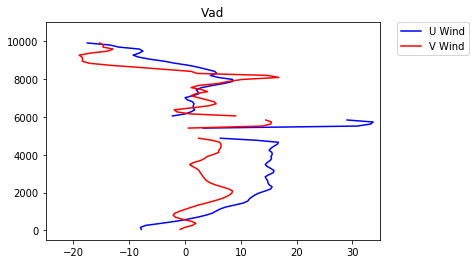

In [13]:
# Without in velocity_azimuth_display function:      
#  mask=velocities.mask
#  velocities[np.where(mask)]=np.nan
fig = plt.figure()
plt.plot(vad_test.u_wind, vad_test.height, 'b-', label='U Wind')
plt.plot(vad_test.v_wind, vad_test.height, 'r-', label='V Wind')
plt.xlim(-25, 35)
plt.ylim(-500, 11000)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [3]:
files = sorted(glob.glob('/home/zsherman/dev/xsapr_sgp/data/05_19_2017/*'))[0:25]

max height 707.971563173  meters
min height 0.0  meters
max height 707.971563173  meters
min height 0.0  meters
max height 703.178622343  meters
min height 0.0  meters
max height 703.178622343  meters
min height 0.0  meters
max height 705.575067734  meters
min height 0.0  meters
max height 703.178622343  meters
min height 0.0  meters
max height 698.38556968  meters
min height 0.0  meters
max height 707.971563173  meters
min height 0.0  meters
max height 684.006521272  meters
min height 0.0  meters
max height 707.971563173  meters
min height 0.0  meters
max height 722.350494361  meters
min height 0.0  meters
max height 731.936408604  meters
min height 0.0  meters
max height 707.971563173  meters
min height 0.0  meters
max height 717.557473224  meters
min height 0.0  meters
max height 712.76460016  meters
min height 0.0  meters
max height 703.178622343  meters
min height 0.0  meters
max height 698.38556968  meters
min height 0.0  meters
max height 698.38556968  meters
min height 0.0  met

KeyboardInterrupt: 

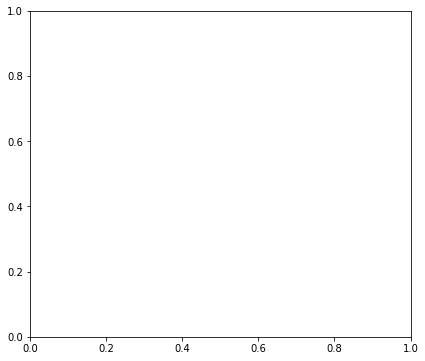

In [16]:
def animate(nframe):
    plt.clf()
    
    radar = pyart.io.read(files[nframe])
    radar_sweep = radar.extract_sweeps([11])
    height = np.linspace(101, 11000, 101)
    valid_ray_min = 16

    # perform a VAD retrieval
    vad = velocity_azimuth_display(
        radar_sweep, 'velocity', z_want=height, gatefilter=None,
        valid_ray_min=valid_ray_min)

    ax1 = fig.add_subplot(121)
    display = pyart.graph.RadarMapDisplay(radar_sweep)
    display.plot_ppi_map('reflectivity', resolution='l',
                         vmin=-8, vmax=64, mask_outside=False,
                         cmap=pyart.graph.cm.NWSRef,
                         lat_lines=None, ax=ax1, lon_lines=None)
    display.basemap.drawcounties()

    ax2 = fig.add_subplot(122)
    plt.plot(vad.u_wind, vad.height, 'b-', label='U Wind')
    plt.plot(vad.v_wind, vad.height, 'r-', label='V Wind')
    plt.xlim(-25, 35)
    plt.ylim(101, 11000)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    del radar
    del radar_sweep

fig = plt.figure(figsize=(15, 6))
anim = animation.FuncAnimation(fig, animate,
                                    frames=len(files))
anim.save('/home/zsherman/vad_jonathan.gif', writer='imagemagick', fps=1)
plt.close()